<a href="https://colab.research.google.com/github/dgalassi99/quant-trading-self-study/blob/main/02_backtesting_risk_management/W8_Hedging_%26_Leverage.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MA Trading Strategy with Leverage

In [1]:
%pip install backtrader
%pip install yfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 10.8 MB/s eta 0:00:00


In [2]:
import yfinance as yf
import backtrader as bt
import numpy as np
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import timedelta

#import the data from yahoo finance
ticker = 'SPY'
ticker = 'GLD'
ticker = 'EEM'
data = yf.download(ticker, period='30y', interval='1d')
#rename columns and adjust for feeding into BT
data = data[['Open', 'High', 'Low', 'Close', 'Volume']]
data.columns = ['open', 'high', 'low', 'close', 'volume']
data.head()

/tmp/ipython-input-2-472266067.py:14: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, period='30y', interval='1d')
[*********************100%***********************]  1 of 1 completed


,open,high,low,close,volume
Date,,,,,
2003-04-14,7.289390,7.340263,7.289390,7.340263,93600
2003-04-15,7.385322,7.449277,7.385322,7.427474,421200
2003-04-16,7.507421,7.543758,7.507421,7.513235,9000
2003-04-17,7.554659,7.569194,7.541577,7.567014,17100
2003-04-21,7.575733,7.576459,7.558291,7.564104,72900


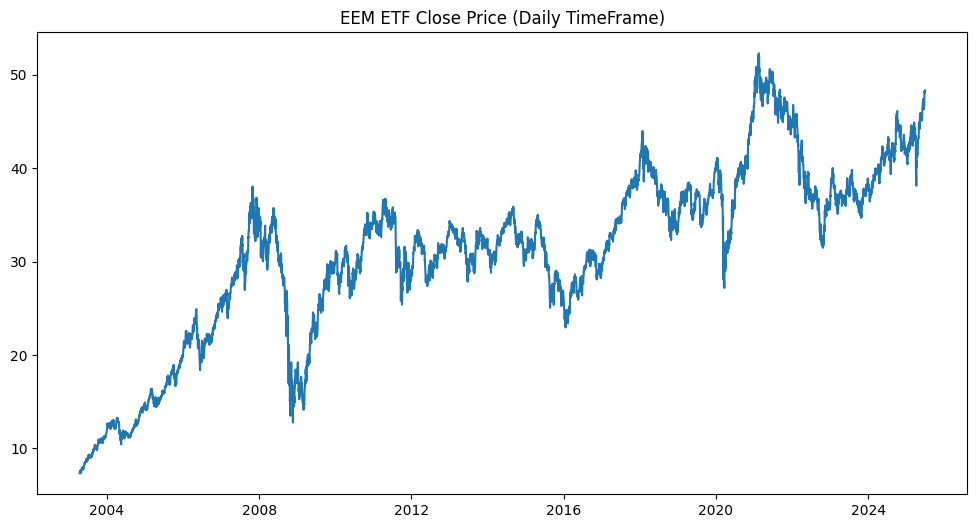

In [3]:
plt.figure(figsize=(12,6))
plt.plot(data['close'])
plt.title(f'{ticker} ETF Close Price (Daily TimeFrame)')
plt.show()

## Backtesting a long-only strategy analyzing return distributions at different leverage levels

The first simulation is aimed at comparing the distribution of return in a randomized simulation. The set up will be the following:

- Run K-backtesting simulation (5-years period) considering to start in a random day and following the MA strategy. This will produce a distribution of yearly returns
- Repeat the previous step by incorporating different leverages and examine resulting metrics

Let's dive in!

### Base Simulation - No Leverage

In [3]:
data.shape
data.head()

,open,high,low,close,volume
Date,,,,,
2003-04-14,7.289395,7.340269,7.289395,7.340269,93600
2003-04-15,7.385325,7.449280,7.385325,7.427477,421200
2003-04-16,7.507423,7.543761,7.507423,7.513237,9000
2003-04-17,7.554660,7.569194,7.541578,7.567014,17100
2003-04-21,7.575735,7.576462,7.558293,7.564106,72900


In [12]:
#--- Strategy class --- Taken from W5 exercise
class BaseMA(bt.Strategy):
    params = dict(ma_fast=20, ma_slow=50)

    def __init__(self):
        self.ma_fast = bt.ind.SMA(self.data.close, period=self.params.ma_fast)
        self.ma_slow = bt.ind.SMA(self.data.close, period=self.params.ma_slow)
        self.crossover = bt.ind.CrossOver(self.ma_fast, self.ma_slow)
        self.order = None

    def log(self, txt, dt=None):
      pass

    def notify_order(self, order):
      pass
    def notify_trade(self, trade):
      pass

    def next(self):
        if self.order:
            return
        if not self.position:
            if self.crossover > 0:
                self.log(f'BUY CREATED, Price: {self.data.close[0]:.2f}')
                self.order = self.buy()
        else:
            if self.crossover < 0:
                self.log(f'SELL CREATED, Price: {self.data.close[0]:.2f}')
                self.order = self.sell()


# --- Backtesting function ---
def run_backtesting(data, strategy, n_runs=20, trading_year_days=252, initial_liquidity=100000):
    results = []

    window_days = trading_year_days * 5  # 5 years ≈ 1260 trading days
    possible_starting_dates = data.index[:-window_days]

    random_start_dates = np.random.choice(possible_starting_dates, size=n_runs, replace=False)

    for starting_date in random_start_dates:
        bt_data = data.loc[starting_date:]
        bt_data = bt_data.iloc[:window_days]

        if len(bt_data) < window_days:
            continue

        cerebro = bt.Cerebro()
        cerebro.broker.setcash(initial_liquidity)
        cerebro.addstrategy(strategy)
        cerebro.broker.setcommission(commission=0.001)
        cerebro.addsizer(bt.sizers.PercentSizer, percents=99)

        feed = bt.feeds.PandasData(dataname=bt_data)
        cerebro.adddata(feed)

        cerebro.run()
        final_value = cerebro.broker.getvalue()
        investment_period = len(bt_data)
        total_return = (final_value - initial_liquidity) / initial_liquidity
        annualized_return = (1 + total_return) ** (252 / investment_period) - 1

        results.append({
            'start_date': pd.to_datetime(starting_date).date(),
            'investment_duration_days': investment_period,
            'final_value': final_value,
            'total_return': total_return,
            'annualized_return': annualized_return
        })

    return pd.DataFrame(results)

In [20]:
df_results = run_backtesting(data, BaseMA, n_runs=1000)
df_results.describe()

,investment_duration_days,final_value,total_return,annualized_return
count,1000.0,1000.000000,1000.000000,1000.000000
mean,1260.0,125180.276500,0.251803,0.040066
std,0.0,35022.212556,0.350222,0.054529
min,1260.0,68301.565496,-0.316984,-0.073413
25%,1260.0,100983.465380,0.009835,0.001959
50%,1260.0,112248.734613,0.122487,0.023378
75%,1260.0,149977.827362,0.499778,0.084440
max,1260.0,262035.534546,1.620355,0.212473


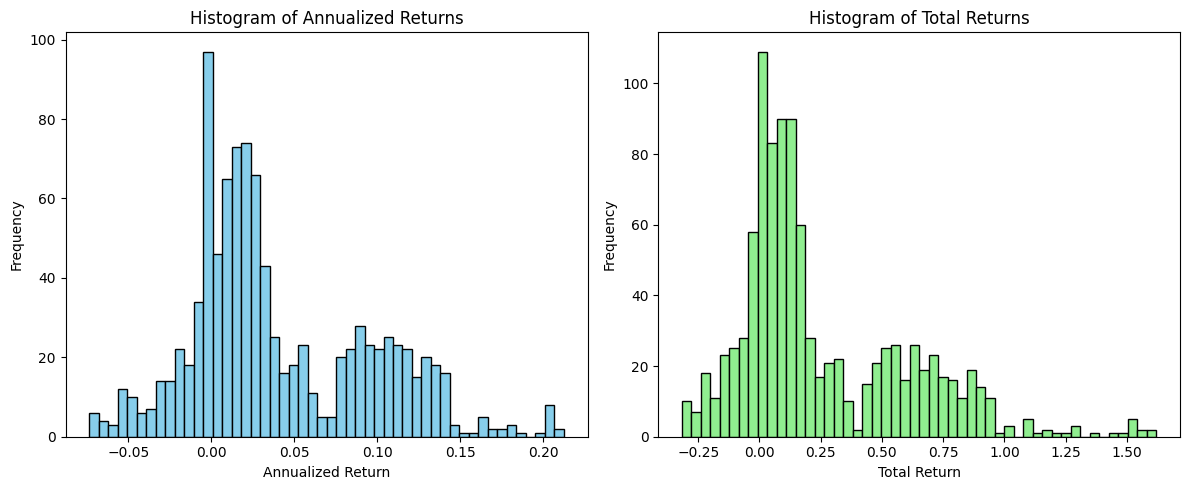

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(df_results['annualized_return'].dropna(), bins=50, color='skyblue', edgecolor='black')
axes[0].set_title('Histogram of Annualized Returns')
axes[0].set_xlabel('Annualized Return')
axes[0].set_ylabel('Frequency')

axes[1].hist(df_results['total_return'].dropna(), bins=50, color='lightgreen', edgecolor='black')
axes[1].set_title('Histogram of Total Returns')
axes[1].set_xlabel('Total Return')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

### What Happens Leveraging?

Unfortunately Backtrader does not allow go trade more than your cash --> no leverage can be implemented

We try to write something without using bakctrader library :)

In [4]:
#copying the starting dataset
df = data.copy()
#setting up the moving averages
ma_slow = 50
ma_fast = 20
df['ma_slow'] = df['close'].rolling(ma_slow).mean()
df['ma_fast'] = df['close'].rolling(ma_fast).mean()
#dropping the data with nan due to rolling windows creation
df = df.dropna()
df.head()

,open,high,low,close,volume,ma_slow,ma_fast
Date,,,,,,,
2003-06-24,8.622995,8.622995,8.546685,8.595378,188100,8.070222,8.579788
2003-06-25,8.617180,8.719654,8.617180,8.666600,1045800,8.096749,8.600319
2003-06-26,8.708026,8.764713,8.692764,8.760353,210600,8.123406,8.624993
2003-06-27,8.771978,8.775612,8.697849,8.719651,373500,8.147534,8.642835
2003-06-30,8.744365,8.744365,8.699306,8.713840,279900,8.170471,8.657370


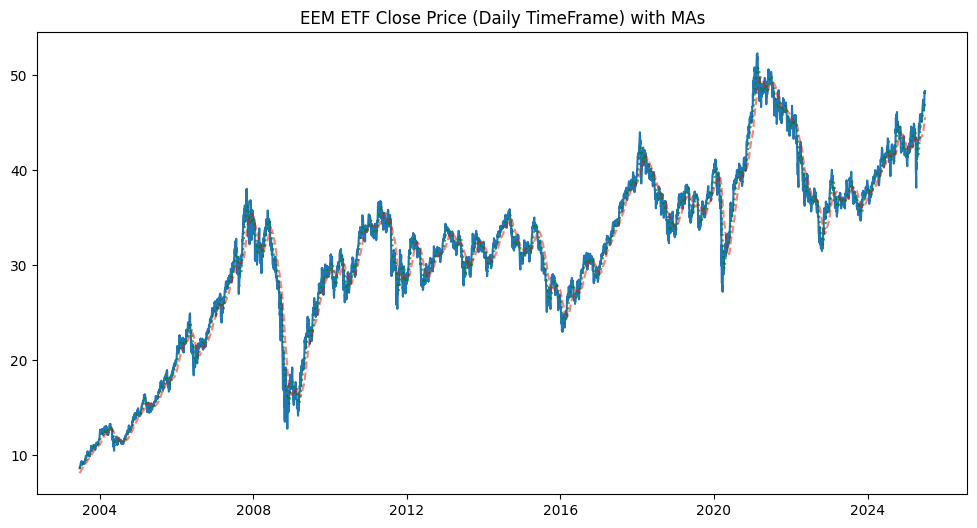

In [5]:
plt.figure(figsize=(12,6))
plt.plot(df['close'])
plt.plot(df['ma_slow'],linestyle = '--', alpha = 0.5, color ='red')
plt.plot(df['ma_fast'],linestyle = ':', alpha = 0.7, color = 'green')
plt.title(f'{ticker} ETF Close Price (Daily TimeFrame) with MAs')
plt.show()

In [6]:
#initialize the signal column
df['signal'] = 0
#detecting the bullish and bearish crossovers
df.loc[(df['ma_fast'] > df['ma_slow']) & (df['ma_fast'].shift(1) <= df['ma_slow'].shift(1)),'signal'] = 1  # crossover up -> buy
df.loc[(df['ma_fast'] < df['ma_slow']) & (df['ma_fast'].shift(1) >= df['ma_slow'].shift(1)),'signal'] = -1 # crossover down -> sell)
#creating the position status
df['position'] = 0  # start with no position
current_position = 0

for i in range(len(df)):
    signal = df['signal'].iloc[i]
    if signal == 1:
        current_position = 1  # enter long
    elif signal == -1:
        current_position = 0  # exit to flat
    df['position'].iloc[i] = current_position

Streaming output truncated to the last 5000 lines.
See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['position'].iloc[i] = current_position
/tmp/ipython-input-6-896870496.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['position'].iloc[i] = current_position
/tmp/ipython-input-6-896870496.py:16: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical ex

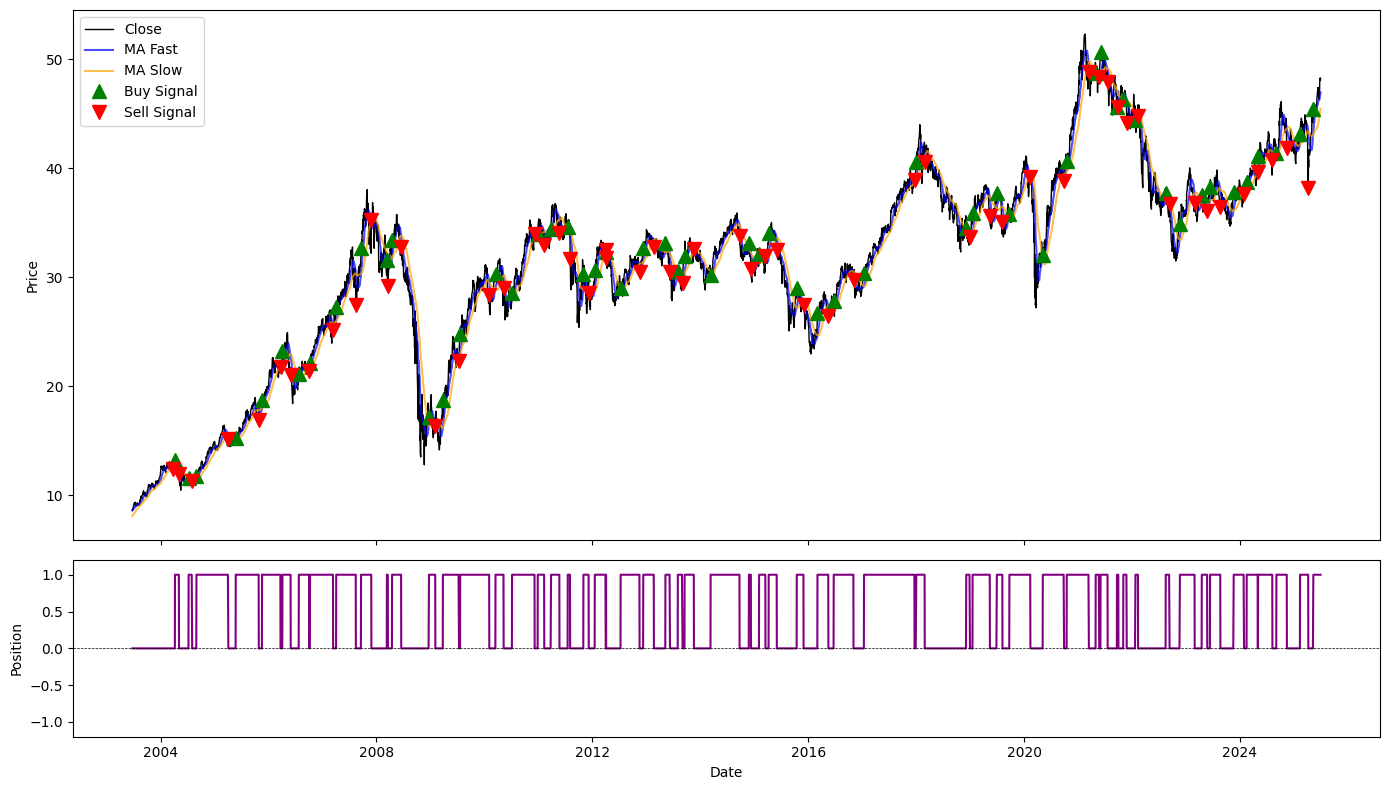

In [70]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14,8), sharex=True, gridspec_kw={'height_ratios':[3,1]})

# --- Price & Moving Averages ---
ax1.plot(df.index, df['close'], label='Close', color='black', linewidth=1)
ax1.plot(df.index, df['ma_fast'], label='MA Fast', color='blue', alpha=0.7)
ax1.plot(df.index, df['ma_slow'], label='MA Slow', color='orange', alpha=0.7)

#--- signal markers ---
ax1.plot(df.loc[df['signal'] == 1].index, df['close'][df['signal'] == 1], '^', markersize=10, color='green', label='Buy Signal')
ax1.plot(df.loc[df['signal'] == -1].index, df['close'][df['signal'] == -1], 'v', markersize=10, color='red', label='Sell Signal')

ax1.legend()
ax1.set_ylabel('Price')

# --- Position plot ---
ax2.plot(df.index, df['position'], color='purple', linewidth=1.5)
ax2.set_ylabel('Position')
ax2.axhline(0, color='black', linewidth=0.5, linestyle='--')
ax2.set_ylim(-1.2, 1.2)

plt.xlabel('Date')
plt.tight_layout()
plt.show()


In [71]:
#ok great now we simulate n_runs by starting on a random date and
#applying teh strategy for an horizon of 5 years
years = 5
trading_days_per_year = 252
investment_horizon = years * trading_days_per_year
initial_capital = 100000 #100k USD as starting capital
n_runs = 1000 #numer of simulations to run
#possible start dates are all without last 5 years if not we dont have the full horizon to use
possible_starting_dates = df.index[:-investment_horizon]
random_start_dates = np.random.choice(possible_starting_dates, size=n_runs, replace=False)

results = []
for starting_date in random_start_dates:

  df_slice = df.loc[starting_date:] #slice from starting date to end
  df_slice = df_slice.iloc[:investment_horizon] #consider only the 5 years after starting date
  if len(df_slice) < investment_horizon: #just to be sure :)
    continue

  df_slice['returns'] = df_slice['close'].pct_change()
  df_slice = df_slice.dropna() #drop the first row as it will have NaN
  #shift returns because we can only trade teh day after whne the market opens
  df_slice['strategy_returns'] = df_slice['returns'] * df_slice['position'].shift(1)
  #compute portfolio cumulative return
  df_slice['portfolio_value'] = initial_capital * (1 + df_slice['strategy_returns']).cumprod()
  #final value and total return
  final_value = df_slice['portfolio_value'].iloc[-1]
  total_return = (final_value - initial_capital) / initial_capital
  #annualized returns
  annualized_return = (1 + total_return) ** (trading_days_per_year / investment_horizon) - 1
  #sharpe ratio
  sharpe_ratio = np.sqrt(trading_days_per_year) * df_slice['strategy_returns'].mean() / df_slice['strategy_returns'].std()
  #max drawdown
  running_max = df_slice['portfolio_value'].cummax()
  drawdown = (df_slice['portfolio_value'] - running_max) / running_max
  max_drawdown = drawdown.min() #take the min as its negative
  #appending results
  results.append({
        'start_date': starting_date,
        'final_value': final_value,
        'total_return': total_return,
        'annualized_return': annualized_return,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown
    })

df_results = pd.DataFrame(results)

/tmp/ipython-input-71-2391831445.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_slice['strategy_returns'] = df_slice['returns'] * df_slice['position'].shift(1)
/tmp/ipython-input-71-2391831445.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_slice['portfolio_value'] = initial_capital * (1 + df_slice['strategy_returns']).cumprod()
/tmp/ipython-input-71-2391831445.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_i

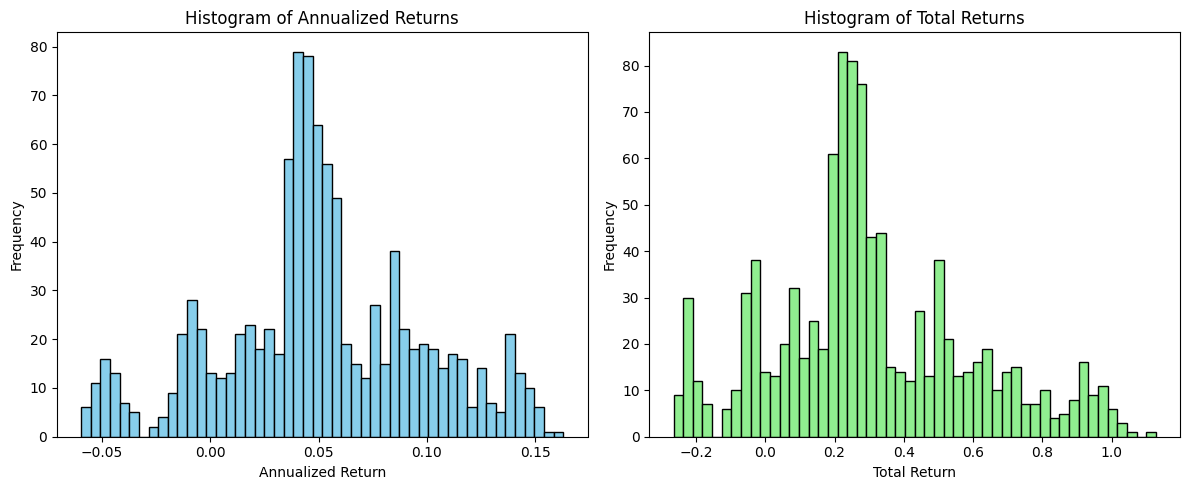

In [74]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

axes[0].hist(df_results['annualized_return'].dropna(), bins=50, color='skyblue', edgecolor='black')
axes[0].set_title('Histogram of Annualized Returns')
axes[0].set_xlabel('Annualized Return')
axes[0].set_ylabel('Frequency')

axes[1].hist(df_results['total_return'].dropna(), bins=50, color='lightgreen', edgecolor='black')
axes[1].set_title('Histogram of Total Returns')
axes[1].set_xlabel('Total Return')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()